In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/aiffel/city

Mounted at /content/drive
/content/drive/MyDrive/aiffel/city


In [ ]:
# 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import cv2
import os

from tensorflow.keras import layers, Input, Model, optimizers, losses
from tensorflow import data, image
from tensorflow.keras.preprocessing.image import random_rotation

import glob

In [ ]:
# 데이터

train_path =  './train'
val_path = './val'

In [ ]:
print("num of train : ", len(os.listdir(train_path))) # 디렉토리 내 모든 파일과 디렉토리 반환
print("num of test :" , len(os.listdir(val_path)))

num of train :  1000
num of test : 5


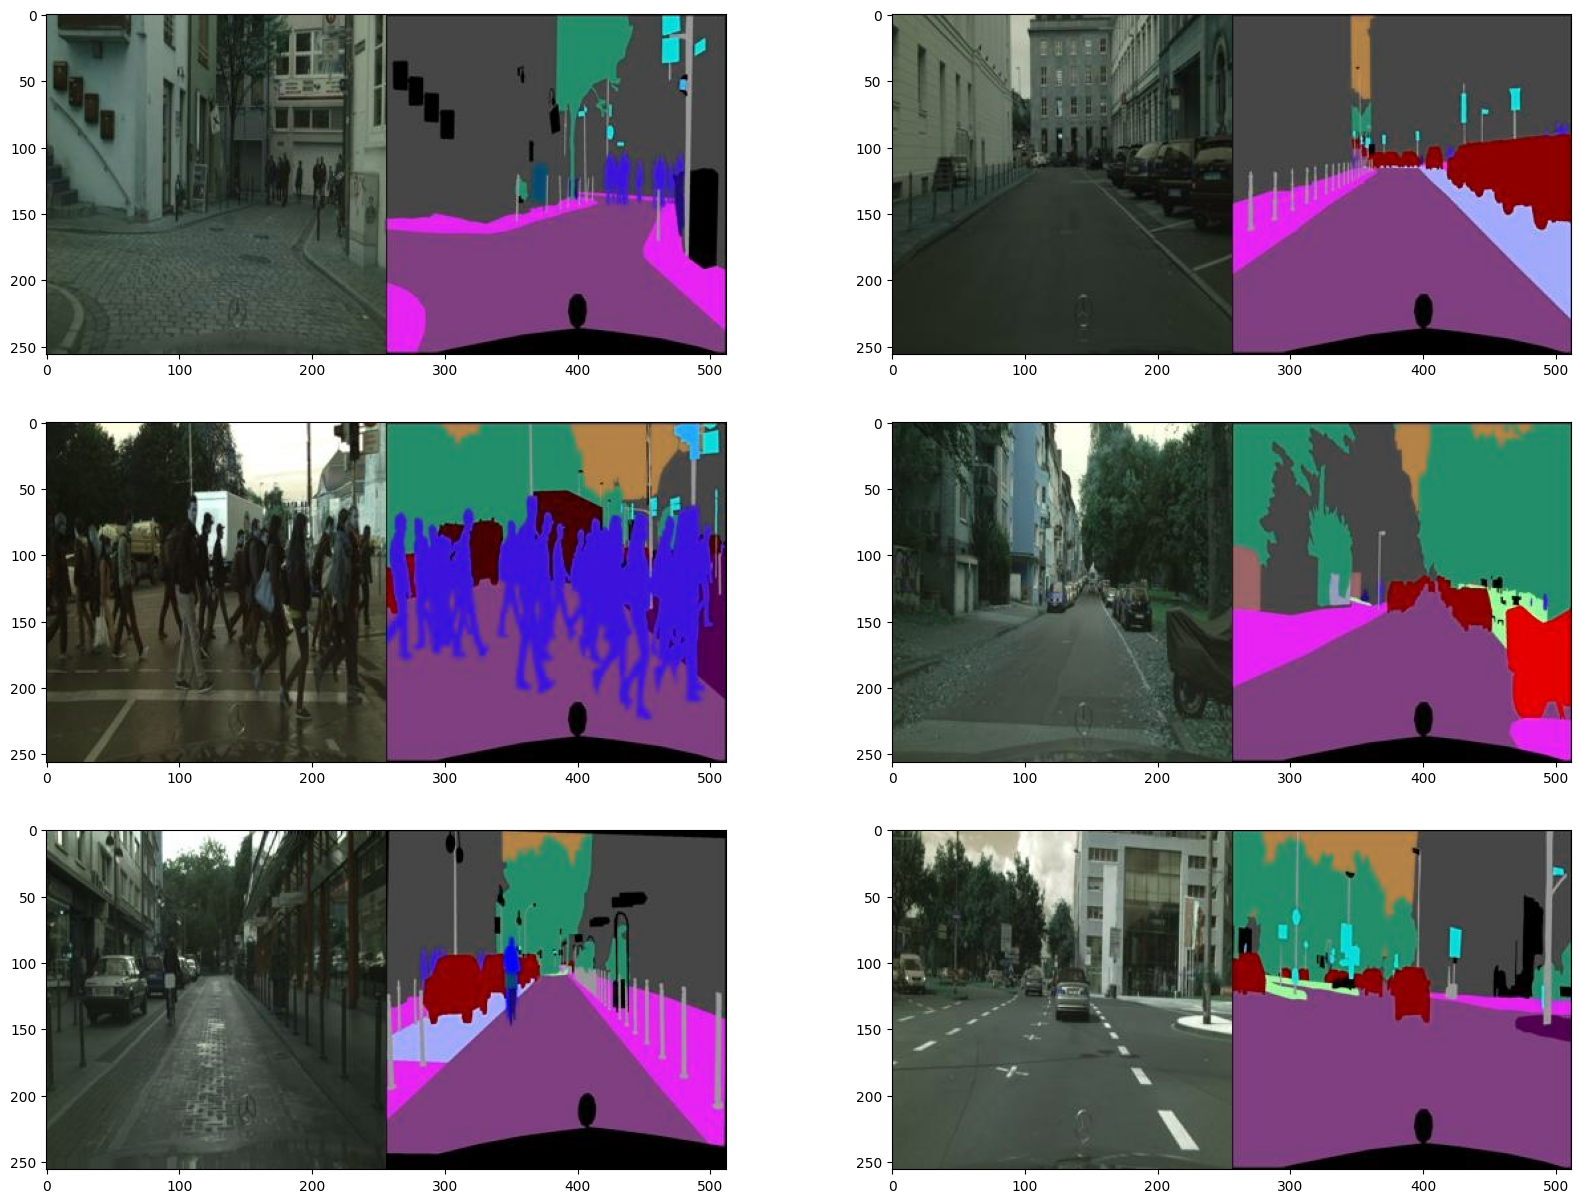

In [ ]:
# train data 시각화
plt.figure(figsize = (20,15))
for i in range(1,7) :
  f = train_path + '/' + os.listdir(train_path)[np.random.randint(800)]
  img = cv2.imread(f, cv2.IMREAD_COLOR) # COLOR 로 데이터 입력
  plt.subplot(3,2,i)
  plt.imshow(img)

In [ ]:
# 이미지 size 확인
f = train_path + '/' + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [ ]:
# 정규화

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

In [ ]:
# 복원
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

In [ ]:
# 이미지
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)

    w = tf.shape(img)[1] // 2  # 그림 절반으로
    real_image = img[:, :w, :]
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

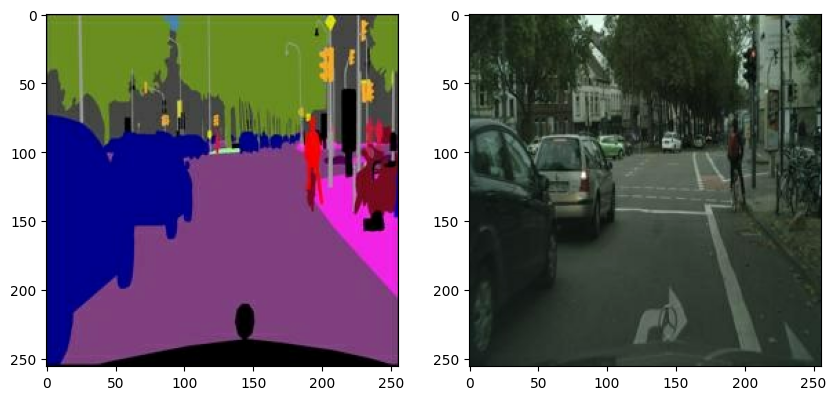

In [ ]:
# 복원 확인
f = train_path + '/' + os.listdir(train_path)[10]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [ ]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다.
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)

    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])

    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)

    return out[...,:3], out[...,3:]

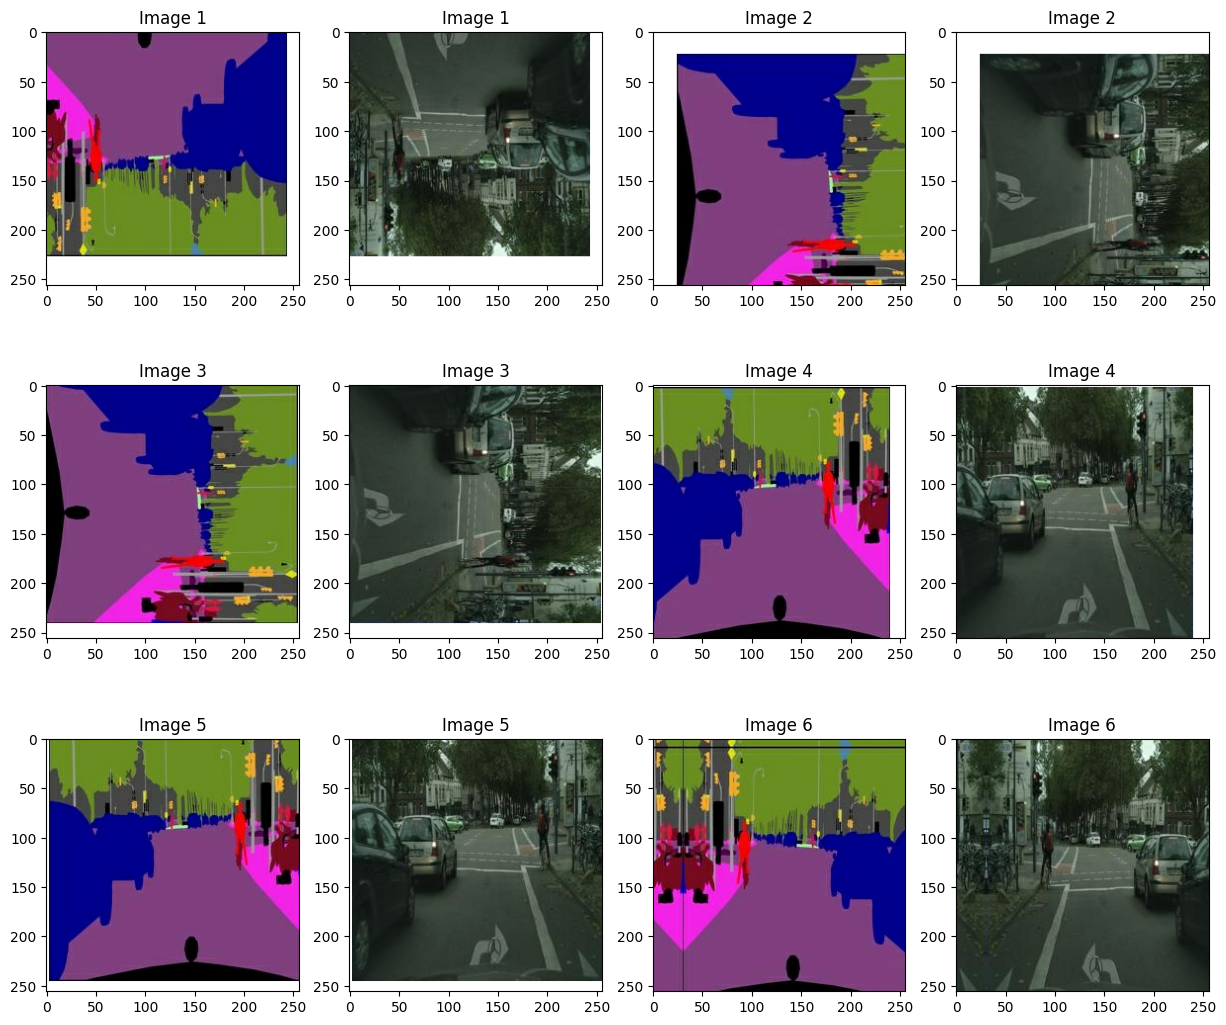

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)

    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1);
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [ ]:
# 전체에 적용
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

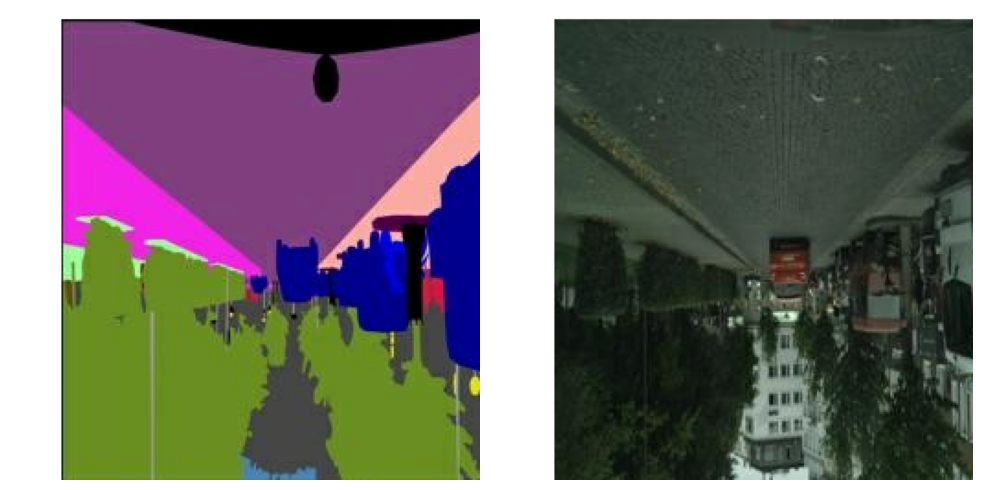

In [ ]:
train_images = data.Dataset.list_files(train_path + '/' + "*.jpg") # 얘때문에 glob 필요
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(colored[0].astype(np.uint8))
plt.tight_layout()


# generator

## encoder

In [ ]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [ ]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]

        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBloc  (None, 64, 64, 128)       131584    
 k)                                                              
                                                                 
 encode_block_2 (EncodeBloc  (None, 32, 32, 256)       525312    
 k)                                                              
                                                                 
 encode_block_3 (EncodeBloc  (None, 16, 16, 512)       2099200   
 k)                                                              
                                                             

## Decoder

In [ ]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [ ]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]

        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))

        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 256)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         2099200   
                                                                 
 decode_block_1 (DecodeBloc  (None, 4, 4, 512)         4196352   
 k)                                                              
                                                                 
 decode_block_2 (DecodeBloc  (None, 8, 8, 512)         4196352   
 k)                                                              
                                                                 
 decode_block_3 (DecodeBloc  (None, 16, 16, 512)       4196352   
 k)                                                              
                                                           

## EncoderDecoderGenerator

In [ ]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [ ]:
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39087360 (149.11 MB)
Trainable params: 39076480 (149.06 MB)
Non-trainable params: 10880 (42.50 KB)
_________________________________________________________________


##UNET

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]

        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))

        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))

        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)

    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)

        features = features[:-1]

        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])

        x = self.last_conv(x)
        return x

    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encode_block_16 (EncodeBlo  (None, 128, 128, 64)         3072      ['input_4[0][0]']             
 ck)                                                                                              
                                                                                                  
 encode_block_17 (EncodeBlo  (None, 64, 64, 128)          131584    ['encode_block_16[0][0]']     
 ck)                                                                                              
                                                                                            

# Discriminator

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act

        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)

        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None

    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)

        if self.use_bn:
            x = self.batchnorm(x)

        if self.act:
            x = self.lrelu(x)
        return x

In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 130, 130, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Ba  (None, 127, 127, 64)      256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33024 (129.00 KB)
Trainable params: 32896 (12

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))

    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)

    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 256, 256, 6)          0         ['input_6[0][0]',             
 )                                                                   'input_7[0][0]']             
                                                                                                  
 disc_block (DiscBlock)      (None, 128, 128, 64)         6144      ['concatenate_7[0][0]'] 

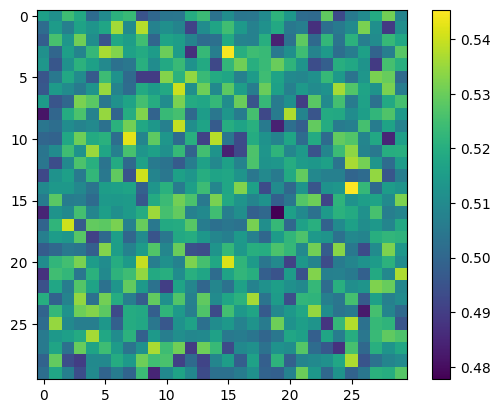

In [ ]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# learning

In [ ]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

In [ ]:
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

In [ ]:
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [ ]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [ ]:
@tf.function
def train_step(segment, real_city):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_city = generator(segment, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segment, fake_city, training=True)
        real_disc = discriminator(segment, real_city, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_city, real_city, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 20

aug_history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (segment, city) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment, city)

    aug_history['g_loss'].append(g_loss.numpy())
    aug_history['l1_loss'].append(l1_loss.numpy())
    aug_history['d_loss'].append(d_loss.numpy())

    print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1]             
Generator_loss:1.3946             
L1_loss:0.2077             
Discriminator_loss:0.4705

EPOCH[2]             
Generator_loss:0.5451             
L1_loss:0.1909             
Discriminator_loss:1.0271

EPOCH[3]             
Generator_loss:1.4983             
L1_loss:0.1488             
Discriminator_loss:0.5500

EPOCH[4]             
Generator_loss:1.5285             
L1_loss:0.2100             
Discriminator_loss:0.9689

EPOCH[5]             
Generator_loss:1.3464             
L1_loss:0.1788             
Discriminator_loss:0.5529

EPOCH[6]             
Generator_loss:1.4615             
L1_loss:0.1774             
Discriminator_loss:0.3638

EPOCH[7]             
Generator_loss:1.1694             
L1_loss:0.1802             
Discriminator_loss:0.6243

EPOCH[8]             
Generator_loss:0.8349             
L1_loss:0.2089             
Discriminator_loss:0.7432

EPOCH[9]             
Generator_loss:1.0077             
L1_loss:0.1498             
Discriminator_loss:

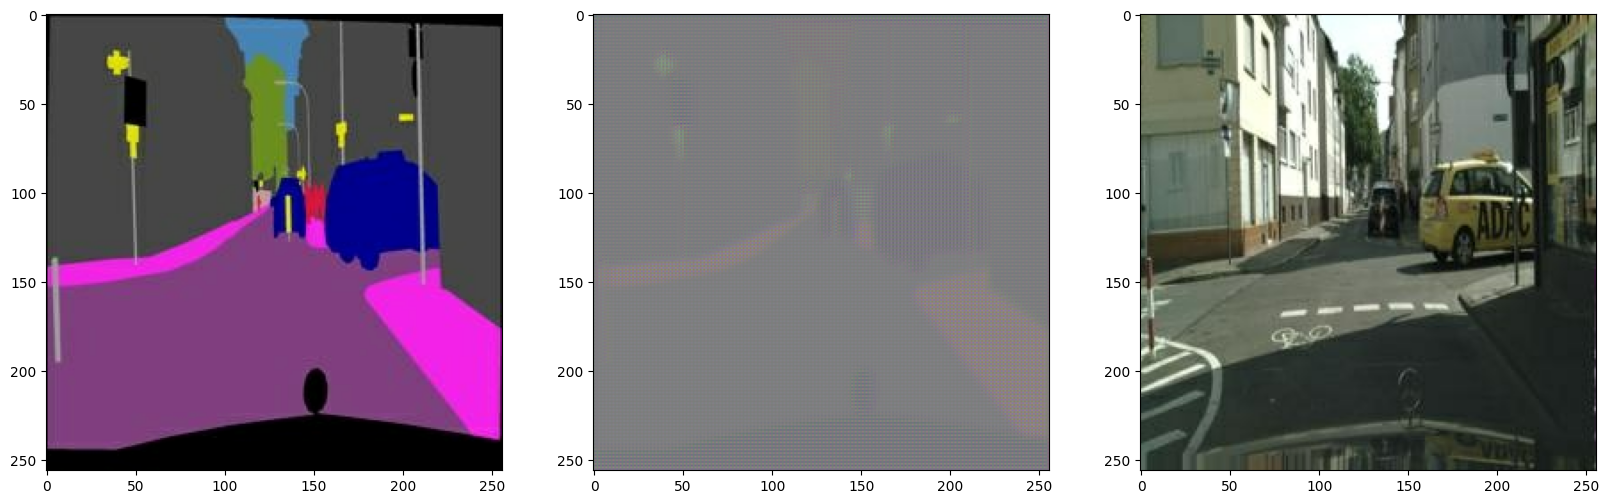

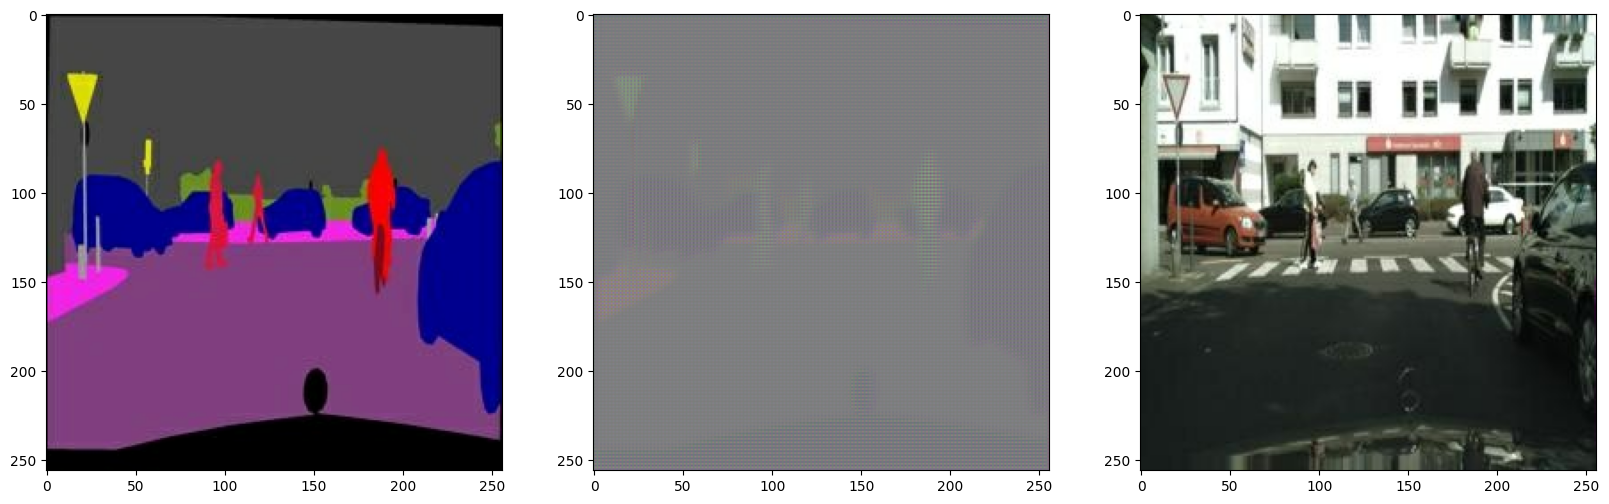

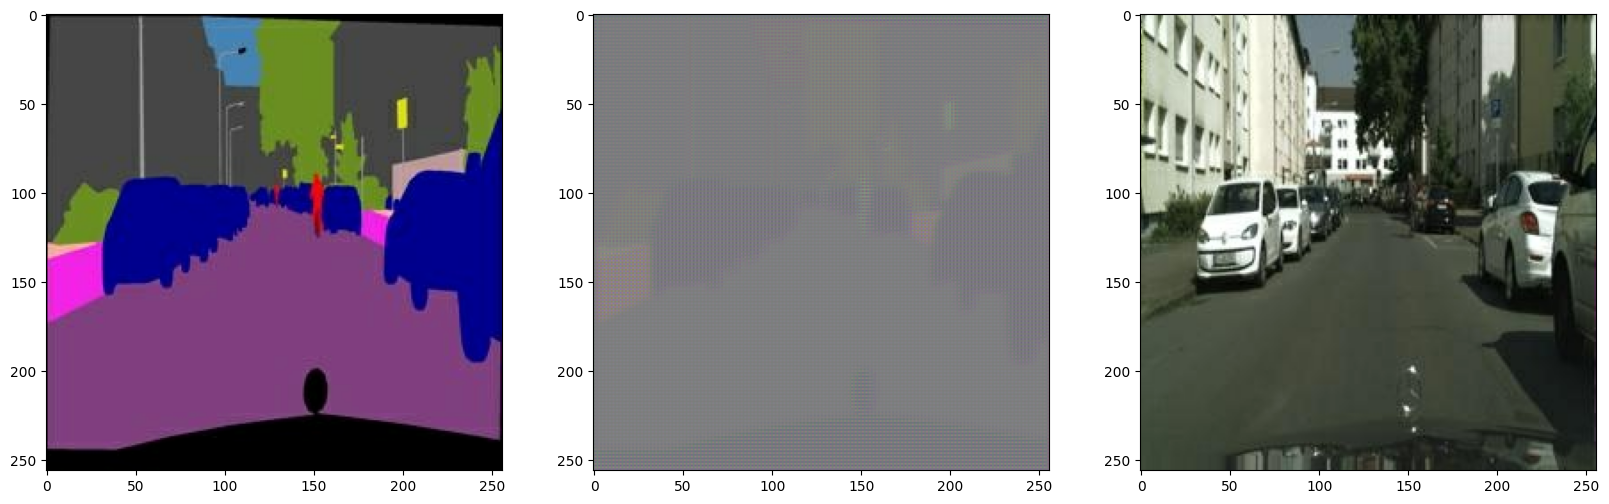

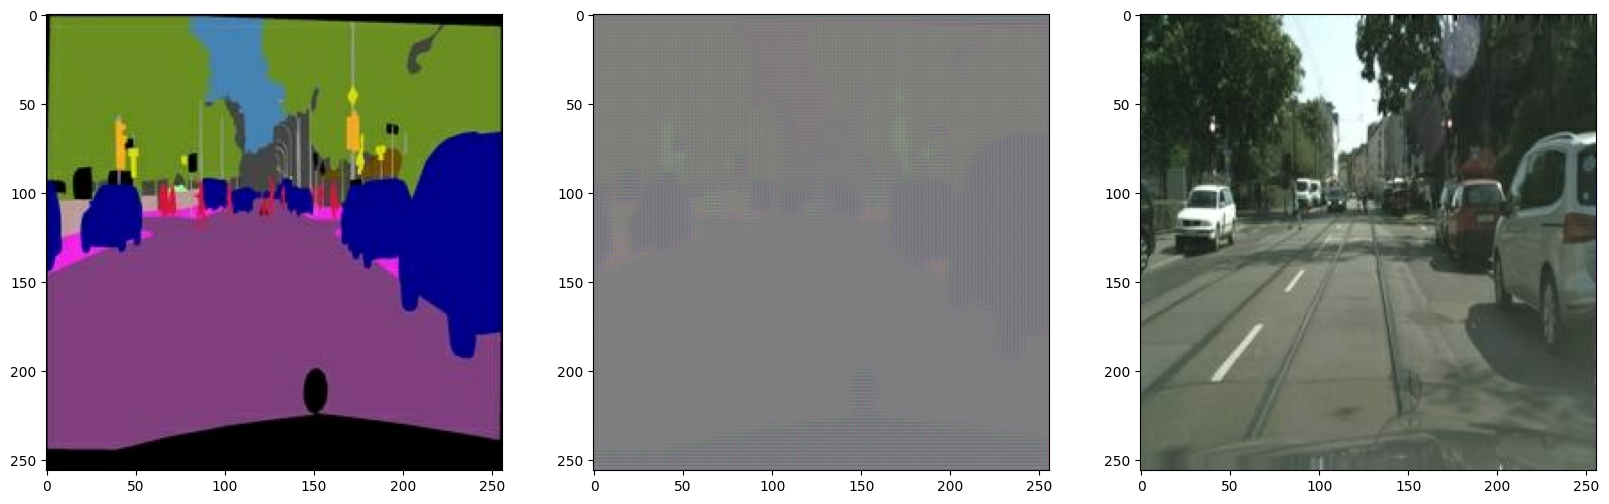

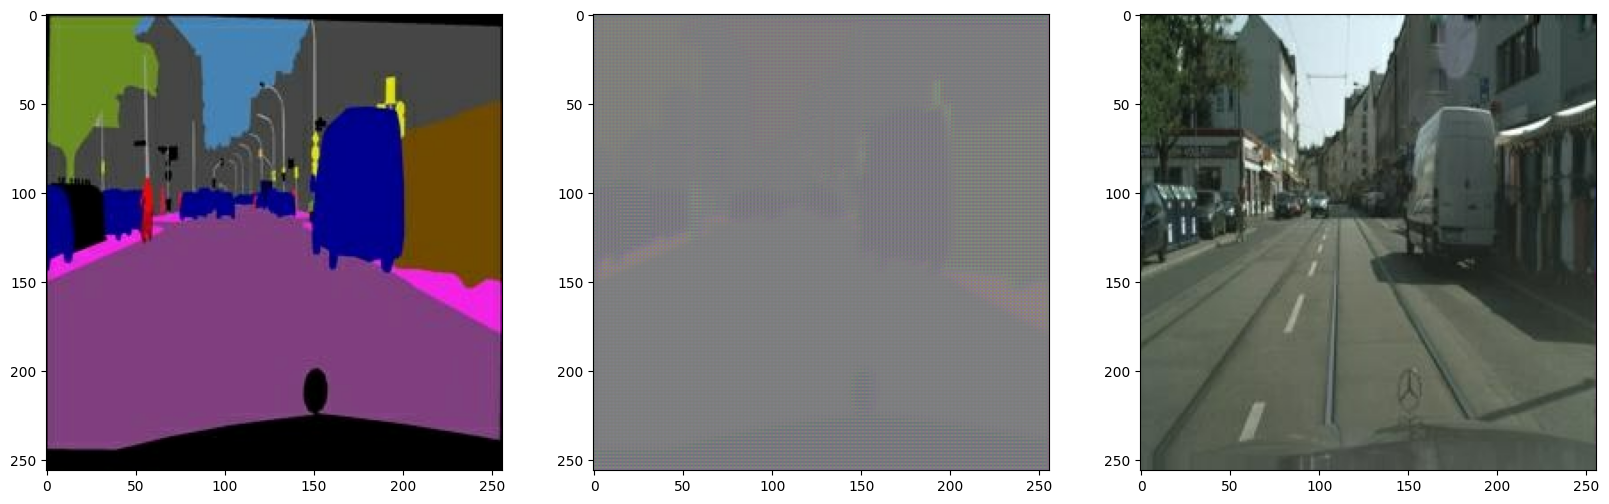

In [ ]:
test_ind = 1

for i in range(len(os.listdir(val_path))):
    f = val_path + '/' + os.listdir(val_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

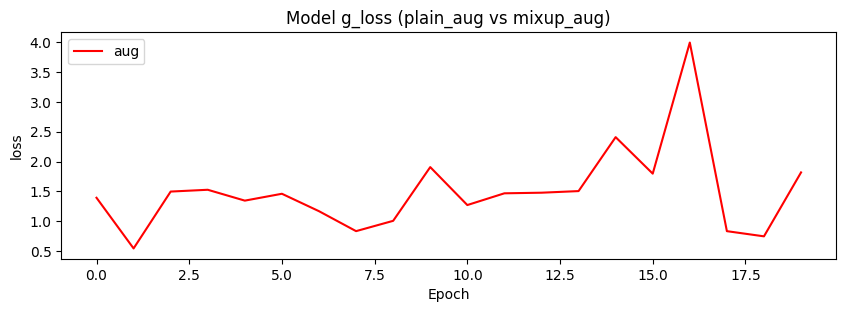

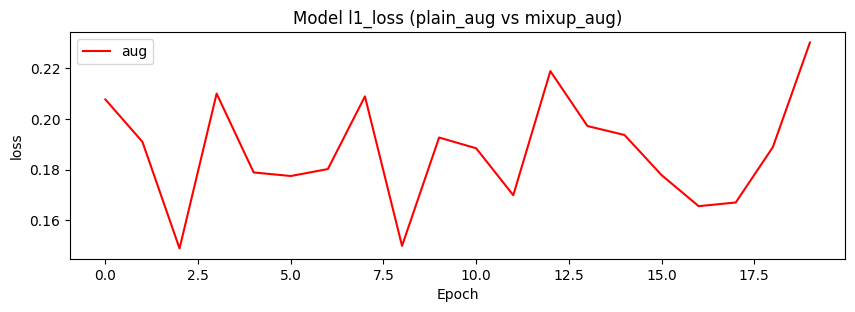

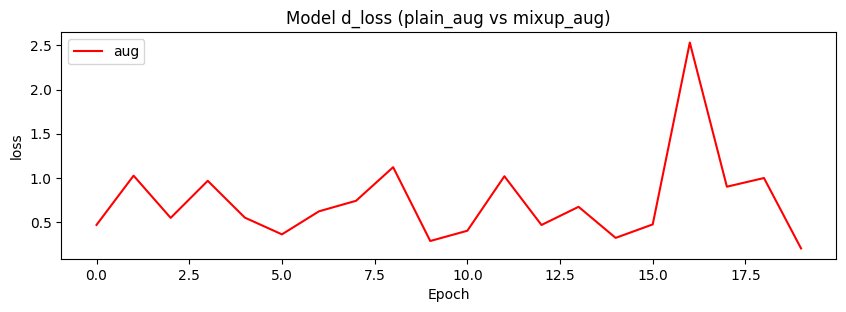

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(aug_history['g_loss'], 'r')
plt.title('Model g_loss (plain_aug vs mixup_aug)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 2)
plt.plot(aug_history['l1_loss'], 'r')
plt.title('Model l1_loss (plain_aug vs mixup_aug)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 3)
plt.plot(aug_history['d_loss'], 'r')
plt.title('Model d_loss (plain_aug vs mixup_aug)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

# 회고

image 를 통한 augmentation 이외에 cutmix라는 방안이 존재한다.

이 방안으로도 진행해 보고싶었지만 시간이 부족하다

이후에 진행 해보기위하여 좀 더 찾아봐야겠다


그리고 얘네 loss 값 왜이래?
잘 나오면서도 아닌것 같아.

epoch 너무 낮게 설정했나?

얘도 나중에 epoch 바꿔서 해보자

그리고 colorbar는 왜 봤지? 얘는 의도 파악을 잘 못하겠다.

너무 어렵다